# Installation

Nowadays, most GPU packages are easy to install: Just do a `Pkg.add("AMDGPU"); Pkg.build("AMDGPU")`, and many of the core ROCm components will be installed. If you have ROCm already installed on your system, set the environment variable `JULIA_DISABLE_AMDGPU_ARTIFACTS=1` before starting Julia, and do a `Pkg.build("AMDGPU")` again.

In [1]:
using Pkg
#Pkg.add("AMDGPU")
Pkg.activate(@__DIR__)

In [1]:
using AMDGPU

With AMDGPU.jl, a good way to check if the package is functional is to call the `versioninfo()` function. Like `Base.versioninfo()`, this will print some information on the available hardware and loaded libraries:

In [2]:
AMDGPU.versioninfo()

HSA Runtime (ready)
- Version: 1.1.0
- Initialized: false
HIP Runtime (ready)
ROCm-Device-Libs (ready)
- Downloaded: true
rocBLAS (ready)
rocFFT (ready)
rocRAND (ready)
rocSPARSE (ready)
rocALUTION (ready)
MIOpen (ready)


Some details of the requirements for a working ROCm setup are documented, if you want to know more specifics: https://amdgpu.juliagpu.org/stable/#Setup-Instructions.

# Array programming

The easiest way to program GPUs in Julia is by using array operations. In AMDGPU.jl, that's done with the `ROCArray` type:

In [3]:
a = ROCArray([1,2,3,4])

4-element ROCVector{Int64}:
 1
 2
 3
 4

In [4]:
a .+= 1

4-element ROCVector{Int64}:
 2
 3
 4
 5

These two operations demonstrate the different tasks that `ROCArray` has:
1. a container for storing GPU data and managing its lifetime
2. a abstraction for executing parallel operations on the GPU

## Scalar indexing

It's crucial to remember that `ROCArray` is an abstraction that derives parallelism from its operations. AMDGPU.jl is **not** a parallelizing compiler, which e.g. means you cannot use element-wise for loops and expect those to execute efficiently on the GPU:

In [5]:
for i in eachindex(a)
    a[i] += 1
end
a

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007f6e400e8be0.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArrays /home/jsamaroo/.julia/packages/GPUArrays/8dzSJ/src/host/indexing.jl:56


4-element ROCVector{Int64}:
 3
 4
 5
 6

As you can see, the operation *did* complete successfully, but with a nasty warning. In fact, the operation did not complete on the GPU, but on the CPU, while fetching and writing each value back separately. Needless to say, that's extremely slow.

Scalar indexing is allowed by default because it's a convenient tool to get up to speed when porting code. You can explicitly enable or disable the feature too:

In [6]:
AMDGPU.allowscalar(false)
a[1]

LoadError: Scalar indexing is disallowed.
Invocation of getindex resulted in scalar indexing of a GPU array.
This is typically caused by calling an iterating implementation of a method.
Such implementations *do not* execute on the GPU, but very slowly on the CPU,
and therefore are only permitted from the REPL for prototyping purposes.
If you did intend to index this array, annotate the caller with @allowscalar.

When porting code, it's often convenient to temporarily allow scalar indexing of certain operations. This can be done using the `@allowscalar` macro:

In [7]:
AMDGPU.@allowscalar a[1]

3

## Array interface

The `ROCArray` type is implemented to resemble `Base.Array`, making it easy to get up to speed, but also making it possible to write generic code that works on all kinds of arrays:

In [8]:
# allocate data
a = ROCArray{Float32}(undef, 10)

10-element ROCVector{Float32}:
 -0.372549
 -0.372549
 -0.372549
 -0.372549
 -0.372549
 -0.372549
 -0.372549
 -0.372549
 -0.372549
 -0.372549

In [9]:
# allocate & initialize
b = ROCArray{Float32}([i for i in 1:length(a)])

10-element ROCVector{Float32}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

In [10]:
copyto!(a, b)

10-element ROCVector{Float32}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

In [11]:
fill!(a, 42)

10-element ROCVector{Float32}:
 42.0
 42.0
 42.0
 42.0
 42.0
 42.0
 42.0
 42.0
 42.0
 42.0

In [12]:
similar(a)

10-element ROCVector{Float32}:
 -0.372549
 -0.372549
 -0.372549
 -0.372549
 -0.372549
 -0.372549
 -0.372549
 -0.372549
 -0.372549
 -0.372549

Some array operations don't take an array type, so it's impossible to dispatch to a GPU-specific version. For those, the AMDGPU module has an unexported version:

In [13]:
c = AMDGPU.ones(length(a))

10-element ROCVector{Float32}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [14]:
d = AMDGPU.rand(length(a))

10-element ROCVector{Float32}:
 0.39369312
 0.60654837
 0.43148258
 0.12269796
 0.4146225
 0.42832327
 0.19583392
 0.96349037
 0.8926966
 0.47283706

## Vendor libraries

For actually useful operations that perform some computations on the GPU, we integrate with AMD's libraries that provide precompiled kernels for many operations:

In [15]:
# rocBLAS
using LinearAlgebra
mul!(d, AMDGPU.rand(10,10), d)

10-element ROCVector{Float32}:
 2.4797223
 2.4381323
 2.3913164
 3.1018968
 2.8257847
 2.2881155
 2.7073734
 2.9817493
 1.8857439
 2.1844478

In [16]:
# rocRAND
using Random
rand!(d)

10-element ROCVector{Float32}:
 0.63391775
 0.48040006
 0.060026173
 0.71439683
 0.4586757
 0.21970661
 0.05693173
 0.7313285
 0.61527807
 0.48223892

In [19]:
# rocALUTION
# TODO: qr(d);

In [17]:
# rocFFT
using AbstractFFTs
fft(d)

LoadError: MethodError: no method matching ROCArray(::Type{ComplexF32}, ::Tuple{Int64})

Note that this is one of the areas where AMDGPU.jl falls short of CUDA.jl: Wrapping libraries is not a difficult task, but it certainly is a tedious one.

So if you're missing a certain wrapper, or you know how to implement e.g. some LinearAlgebra interface, please consider contributing to AMDGPU.jl! The rocBLAS APIs are documented, https://rocblas.readthedocs.io/en/latest/functions.html#rocblas-functions, but often require domain expertise to properly interpret them and implement high-level wrappers. You can often look at the CUBLAS https://docs.nvidia.com/cuda/cublas/index.html#using-the-cublas-api if the rocBLAS documentation is lacking.

## Higher-order abstractions

Although the ROCArray type and its support for AMD's vendor libraries is nice, it isn't really novel and could as well have been implemented in Python (and libraries like CuPy do exactly that). The real flexibility of Julia's arrays comes from its higher-order abstractions, where you combine the abstraction with custom code:

In [18]:
a = AMDGPU.ones(10)
broadcast(a) do x
    x += 1
end

10-element ROCVector{Float32}:
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0

In [19]:
# or written more succinctly:
a .+ 1

10-element ROCVector{Float32}:
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0

These abstractions are really powerful, because while we only need to provide a single generic implementation in AMDGPU.jl, it makes it possible to generate specialized kernels for your application. Many more are supported:

In [20]:
map(a) do x
    x + 1
end

10-element ROCVector{Float32}:
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0

In [21]:
reduce(+, a)

10.0f0

In [22]:
accumulate(+, a)

LoadError: Scalar indexing is disallowed.
Invocation of getindex resulted in scalar indexing of a GPU array.
This is typically caused by calling an iterating implementation of a method.
Such implementations *do not* execute on the GPU, but very slowly on the CPU,
and therefore are only permitted from the REPL for prototyping purposes.
If you did intend to index this array, annotate the caller with @allowscalar.

It is important to note here that **AMDGPU.jl is not a tensor compiler**. It implements these abstractions directly, and generates scalar kernels. Multiple operations are generally not fused together, and generic functions that operate on other arrays (like mapping over `eachcol`, or using `eachslice`) do not directly result in a GPU kernel:

In [23]:
a = AMDGPU.ones(10, 10)
broadcast(eachcol(a)) do x
    sum(x)
end

10-element Vector{Float32}:
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0

Performing the `sum` within the `map` results in one kernel launch per column, which is slow and doesn't efficiently use the GPU:

In [24]:
using BenchmarkTools
@benchmark broadcast(eachcol($a)) do x
    sum(x)
end

BenchmarkTools.Trial: 202 samples with 1 evaluation.
 Range (min … max):  23.224 ms …  25.483 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     24.979 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   24.836 ms ± 344.964 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                                                     ▅█▃        
  ▄▁▁▁▁▁▁▆▄▁▄▁▄▄▄▁▄▁▁▁▁▄▁▁▁▁▁▁▁▆▁▁▁▁▇█▆▆▄▄██▆▆▁▆█▁▄▆█████▄▁▁▁▆ ▆
  23.2 ms       Histogram: log(frequency) by time      25.2 ms <

 Memory estimate: 133.03 KiB, allocs estimate: 2912.

Instead, if the array operation supports it, you should merge them into a single invocation:

In [25]:
sum(a; dims=2)

10×1 ROCMatrix{Float32}:
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0

In [27]:
@benchmark sum(a; dims=2)

BenchmarkTools.Trial: 2134 samples with 1 evaluation.
 Range (min … max):  271.586 μs …   2.882 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):       2.332 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):     2.335 ms ± 145.720 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                                                        ▃█▆▄▄▂▁  
  ▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▇███████ █
  272 μs        Histogram: log(frequency) by time       2.53 ms <

 Memory estimate: 14.11 KiB, allocs estimate: 278.

In other cases, the operation will just refuse the compile because very few array operations are supported in actual device code:

In [28]:
broadcast(a, eachcol(a)) do x,Y
    x + sum(Y)
end

LoadError: GPU compilation of kernel broadcast_kernel(AMDGPU.ROCKernelContext, ROCDeviceMatrix{Float32, 1}, Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}, var"#11#12", Tuple{Base.Broadcast.Extruded{ROCDeviceMatrix{Float32, 1}, Tuple{Bool, Bool}, Tuple{Int64, Int64}}, Base.Broadcast.Extruded{Vector{ROCVector{Float32}}, Tuple{Bool}, Tuple{Int64}}}}, Int64) failed
KernelError: passing and using non-bitstype argument

Argument 4 to your kernel function is of type Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}, var"#11#12", Tuple{Base.Broadcast.Extruded{ROCDeviceMatrix{Float32, 1}, Tuple{Bool, Bool}, Tuple{Int64, Int64}}, Base.Broadcast.Extruded{Vector{ROCVector{Float32}}, Tuple{Bool}, Tuple{Int64}}}}, which is not isbits:
  .args is of type Tuple{Base.Broadcast.Extruded{ROCDeviceMatrix{Float32, 1}, Tuple{Bool, Bool}, Tuple{Int64, Int64}}, Base.Broadcast.Extruded{Vector{ROCVector{Float32}}, Tuple{Bool}, Tuple{Int64}}} which is not isbits.
    .2 is of type Base.Broadcast.Extruded{Vector{ROCVector{Float32}}, Tuple{Bool}, Tuple{Int64}} which is not isbits.
      .x is of type Vector{ROCVector{Float32}} which is not isbits.



Tensor packages like Tullio.jl can help here, making it possible to express complex expressions in a way that can still get compiled to a single kernel (although it doesn't currently work with AMDGPU):

In [30]:
#Pkg.add(["Tullio", "ROCKernels", "KernelAbstractions"])
#using Tullio
using AMDGPU, ROCKernels, KernelAbstractions

In [31]:
# TODO: @tullio x[i,j] := a[i,j] + a[k,j]

At some point you may need even more control, or better performance. For that, you can write your own kernels.

# Kernel programming

Where array operations have implicit parallelism that AMDGPU.jl can use to execute the operation in parallel on your GPU, with kernels the programmer is responsible to apply the available parallel execution resources to the operation at hand.

At a high level, that's pretty easy, you just need to write a scalar function and launch that function in parallel using the `@roc` macro and its `groupsize` keyword argument:

In [37]:
function vadd(c, a, b)
    i = workitemIdx().x
    c[i] = a[i] + b[i]
    return
end

a = ROCArray(1:10)
b = ROCArray(2:2:20)
c = similar(a)
wait(@roc groupsize=length(a) vadd(c, a, b))
sleep(1)
c

10-element ROCVector{Int64}:
  3
  6
  9
 12
 15
 18
 21
 24
 27
 30

But kernel programming quickly becomes much more tricky, because:
- you need to respect hardware limitations
- you need to efficiently use hardware resources
- not every operation maps cleanly on a scalar kernel

## Hardware limitations

For example, let's run our `vadd` kernel on a larger array:

In [38]:
a = ROCArray(1:100000)
b = ROCArray(2:2:200000)
c = similar(a)
wait(@roc groupsize=length(a) vadd(c, a, b))

LoadError: ArgumentError: Group dimensions too large

The reason this fails is due to launching too many threads:

In [39]:
Int(AMDGPU.max_group_size(first(AMDGPU.isas(get_default_agent()))))

1024

Instead, we need to launch multiple so-call *workgroups* and adapt our kernel index calculation:

In [40]:
function vadd(c, a, b)
    i = workitemIdx().x + (workgroupIdx().x - 1) * workgroupDim().x
    if i <= length(a)
        c[i] = a[i] + b[i]
    end
    return
end
wait(@roc groupsize=1024 gridsize=length(a) vadd(c, a, b))
c

100000-element ROCVector{Int64}:
      3
      6
      9
     12
     15
     18
     21
     24
     27
     30
     33
     36
     39
      ⋮
 299967
 299970
 299973
 299976
 299979
 299982
 299985
 299988
 299991
 299994
 299997
 300000

### Occupancy API

Hard-coding a limit of 1024 threads, or even looking up the device limit, is insufficient. In reality, maximum number of threads you can launch also depends on the kernel, and how many hardware resources it uses.

I'd appreciate any help figuring out how to expose the occupancy API in the HIP library, or even writing one from scratch!

## Parallel programming

Another problem with GPU programming is that not all operations map cleanly onto scalar kernels. As a simple example, let's try and implement a kernel that reduces all the values in an array according to a given operation.

### Naive loop

You might start off with a simple `for` loop doing the reduction on the GPU as you would on the CPU:

In [41]:
function reduce_singlethread(op, a, b)
    for i in 1:length(a)
        b[] = op(b[], a[i])
    end
    return
end

a = ROCArray(1:16)
b = ROCArray([0])
wait(@roc groupsize=1 reduce_singlethread(+, a, b))
AMDGPU.@allowscalar b[] # TODO: This is broken!

16

In [42]:
# just to be sure
sum(1:16)

136

In [58]:
@benchmark wait(@roc groupsize=1 reduce_singlethread(+, $(AMDGPU.rand(Int, 1024*1024)), $(AMDGPU.zeros(Int, 1))))

BenchmarkTools.Trial: 17 samples with 1 evaluation.
 Range (min … max):  276.655 ms … 315.992 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     297.462 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   295.198 ms ±  13.165 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █     ▁    ▁▁ ▁   ▁▁            ▁▁█    ▁            ▁    ▁ ▁▁  
  █▁▁▁▁▁█▁▁▁▁██▁█▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁███▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█▁██ ▁
  277 ms           Histogram: frequency by time          316 ms <

 Memory estimate: 113.55 KiB, allocs estimate: 3907.

This is a bad implementation though! It only uses a single thread, defeating the point of using a GPU with its thousands of threads.

### Atomics

To benefit from the GPU, we *need* to launch multiple threads. Since that would trample over the output value, we could try and use atomics:

In [49]:
function reduce_atomic(op, a, b)
    i = workitemIdx().x + (workgroupIdx().x - 1) * workgroupDim().x
    @atomic b[1] = op(b[1], a[i])
    return
end

a = ROCArray(1:16)
b = ROCArray([0])
wait(@roc groupsize=length(a) reduce_atomic(+, a, b))
AMDGPU.@allowscalar b[]

136

In [57]:
@benchmark wait(@roc groupsize=1024 gridsize=1024*1024 reduce_atomic(+, $(AMDGPU.rand(Int, 1024*1024)), $(AMDGPU.zeros(Int, 1))))

BenchmarkTools.Trial: 2234 samples with 1 evaluation.
 Range (min … max):  1.195 ms …   2.843 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.238 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.230 ms ± 176.707 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                                                  █▃ ▂         
  ▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄██▅█▇▅▅▄▄▃▃ ▃
  1.2 ms          Histogram: frequency by time        2.42 ms <

 Memory estimate: 6.62 KiB, allocs estimate: 145.

This still isn't great though: Atomic operations are expensive, and result in serialization of execution.

### Parallel block reduction

We really want a kind of parallel reduction where threads can indepedently perform computations, only to synchronize when absolutely necessary. One possible such parallel strategy looks as follows:

<div>
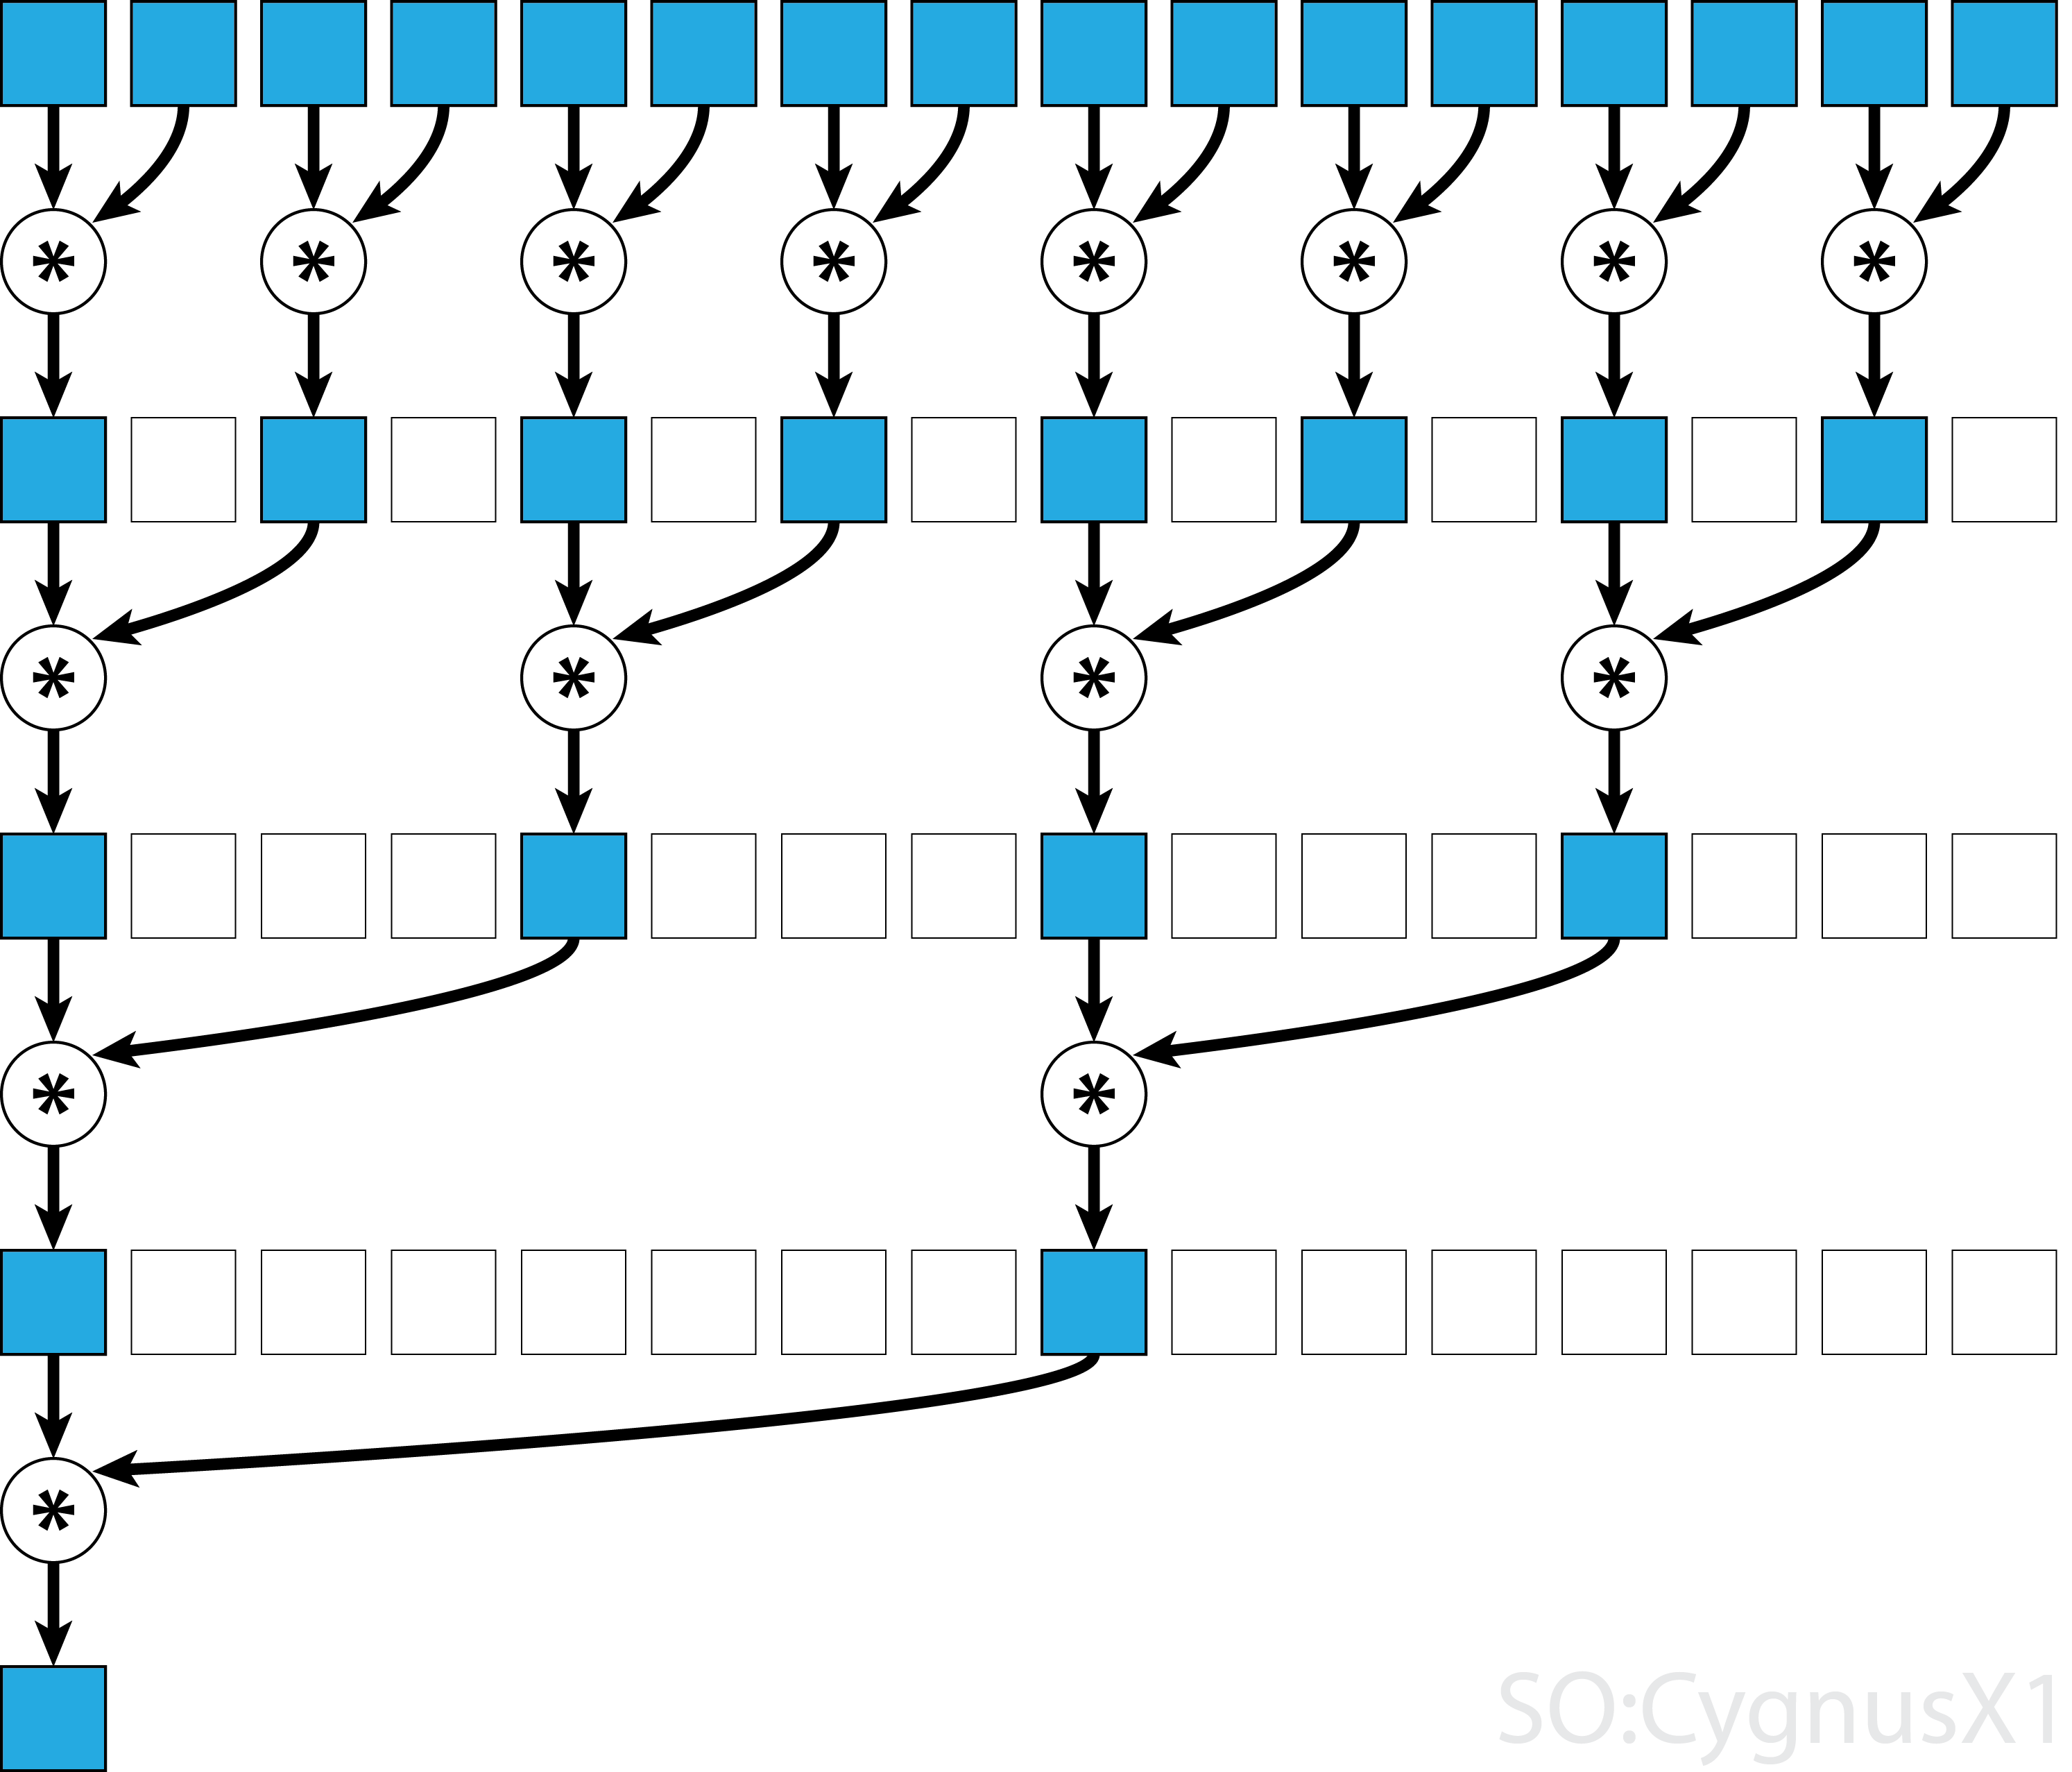
</div>

These kinds of parallel algorithms can be tricky to implement though, so let's start with a single-block version:

In [52]:
function reduce_block(op, a, b)
    elements = workgroupDim().x*2
    thread = workitemIdx().x

    # parallel reduction of values in a block
    d = 1
    while d < elements
        sync_workgroup()
        index = 2 * d * (thread-1) + 1
        @inbounds if index <= elements && index+d <= length(a)
            @rocprintf("thread %d: a[%d] + a[%d] = %d + %d = %d\n", thread, index, index+d, a[index], a[index+d], op(a[index], a[index+d]))
            a[index] = op(a[index], a[index+d])
        end
        d *= 2
        thread == 1 && @rocprintf("\n")
    end
    
    if thread == 1
        b[] = a[1]
    end
    
    return
end

a = ROCArray(1:16)
b = ROCArray([0])
wait(@roc groupsize=cld(length(a),2) reduce_block(+, a, b))
AMDGPU.@allowscalar b[]

thread 8: a[15] + a[16] = 15 + 16 = 31

thread 4: a[13] + a[15] = 27 + 31 = 58

thread 2: a[9] + a[13] = 42 + 58 = 100

thread 1: a[1] + a[9] = 36 + 100 = 136



136

Now let's extend that to a reduction of the entire array (with more elements than fit in a single block) using a simple `for` loop that first reduces across blocks. Such loops aren't always bad: Here, the loop is executed by all threads, in parallel, so we don't throw away the parallel nature of the GPU:

In [54]:
function reduce_grid(op, a, b)
    elements = workgroupDim().x*2
    thread = workitemIdx().x
    
    # serial reduction of values across blocks
    i = thread+elements
    while i <= length(a)
        a[thread] = op(a[thread], a[i])
        i += elements
    end

    # parallel reduction of values in a block
    d = 1
    while d < elements
        sync_workgroup()
        index = 2 * d * (thread-1) + 1
        @inbounds if index <= elements && index+d <= length(a)
            a[index] = op(a[index], a[index+d])
        end
        d *= 2
    end
    
    if thread == 1
        b[] = a[1]
    end
    
    return
end

a = ROCArray(1:16)
b = ROCArray([0])
wait(@roc groupsize=cld(length(a),2) reduce_grid(+, a, b))
AMDGPU.@allowscalar b[]

136

In [59]:
@benchmark wait(@roc groupsize=1024 reduce_grid(+, $(AMDGPU.rand(Int, 1024*1024)), $(AMDGPU.zeros(Int, 1))))

BenchmarkTools.Trial: 2236 samples with 1 evaluation.
 Range (min … max):  1.252 ms …  2.753 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.215 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.232 ms ± 87.541 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                                                █             
  ▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▅█▆▅▆▃▄▃▃▄▃▃▃ ▂
  1.25 ms        Histogram: frequency by time        2.45 ms <

 Memory estimate: 6.52 KiB, allocs estimate: 142.

It should be quite a bit better (although it doesn't look like it because of a limit in the `wait` function), but not ideal since we're only launching a single workgroup now. That's still underutilizing the GPU, which needs multiple workgroups so that it can switch between them to hide latency.


### Atomic grid reduction

If we want to launch multiple workgroups performing block reduction in parallel, we need a way to reduce the resulting value from each block. Sadly, we can't perform that step in parallel: Workgroups are independent, and may not even run at the same time, so we can't synchronize between threads from different workgroups.

However, going back to the beginning, we can use atomics to directly write to the output from each workgroup:

In [62]:
function reduce_grid_atomic(op, a, b)
    elements = workgroupDim().x*2
    thread = workitemIdx().x
    block = workgroupIdx().x
    offset = (block-1) * elements

    # parallel reduction of values in a block
    d = 1
    while d < elements
        sync_workgroup()
        index = 2 * d * (thread-1) + 1
        @inbounds if index <= elements && offset+index+d <= length(a)
            a[offset+index] = op(a[offset+index], a[offset+index+d])
        end
        d *= 2
    end
    
    # atomic reduction of this block's value
    if thread == 1
        @atomic b[1] = op(b[1], a[offset + 1])
    end
    
    return
end

a = ROCArray(1:16)
b = ROCArray([0])
wait(@roc groupsize=2 gridsize=4 reduce_grid_atomic(+, a, b))
AMDGPU.@allowscalar b[]

36

In [61]:
@benchmark wait(@roc groupsize=1024 gridsize=1024*512 reduce_grid_atomic(+, $(AMDGPU.rand(Int, 1024*1024)), $(AMDGPU.zeros(Int, 1))))

BenchmarkTools.Trial: 2180 samples with 1 evaluation.
 Range (min … max):  1.248 ms …   2.765 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.264 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.286 ms ± 144.728 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                                             █▃   ▁            
  ▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▄██▄▃▄█▂▃▃▃▂▂▂▂▂▂ ▂
  1.25 ms         Histogram: frequency by time        2.61 ms <

 Memory estimate: 6.52 KiB, allocs estimate: 142.

### Shared memory

Another common optimization comes from the fact that blocks of threads are executed on separate processors that have their own memory shared between the threads running on that multiprocessor. Accessing that memory is faster than going to global memory, so it is often used for caching loads, and for communicating betweent threads. Both those aspects apply here:

In [64]:
function reduce_grid_atomic_shmem(op, a::AbstractArray{T}, b) where {T}
    elements = workgroupDim().x*2
    thread = workitemIdx().x
    block = workgroupIdx().x
    offset = (block-1) * elements

    # shared mem to buffer memory loads
    shared = ROCDeviceArray(2048, AMDGPU.alloc_local(:local, T, 2048))
    @inbounds shared[thread] = a[offset+thread]
    @inbounds shared[thread+workgroupDim().x] = a[offset+thread+workgroupDim().x]

    # parallel reduction of values in a block
    d = 1
    while d < elements
        sync_workgroup()
        index = 2 * d * (thread-1) + 1
        @inbounds if index <= elements && offset+index+d <= length(a)
            shared[index] = op(shared[index], shared[index+d])
        end
        d *= 2
    end
    
    # atomic reduction
    if thread == 1
        @atomic b[] = op(b[], shared[1])
    end
    
    return
end

a = ROCArray(1:16)
b = ROCArray([0])
wait(@roc groupsize=4 gridsize=4*2 reduce_grid_atomic_shmem(+, a, b))
AMDGPU.@allowscalar b[]

136

In [65]:
@benchmark wait(@roc groupsize=1024 gridsize=1024*512 reduce_grid_atomic_shmem(+, $(AMDGPU.rand(Int, 1024*1024)), $(AMDGPU.zeros(Int, 1))))

BenchmarkTools.Trial: 2178 samples with 1 evaluation.
 Range (min … max):  1.215 ms …   2.760 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.265 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.288 ms ± 109.596 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                                                ▂█▆▃▄▅▅▁▁▃     
  ▃▁▇▁▄▅▃▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▇███████████▆▁▆ █
  1.22 ms      Histogram: log(frequency) by time       2.5 ms <

 Memory estimate: 6.52 KiB, allocs estimate: 142.

The performance improvement isn't great, but that's because I'm using a powerful GPU with lots of global memory bandwith. On older or lower-end GPUs, using shared memory would be valuable.

### Conclusion

And like that, the story keeps going. We're already at some decent level of performance, but there's still ways to go. CUDA.jl has a far faster `sum` implementation, and we'd love if interested contributors would want to try their hand at porting it to AMDGPU.jl!

Ultimately though, this kind of implementation and optimization isn't specific to AMDGPU.jl. It's exactly the same principles as with HIP C++, at mostly the same abstraction level, just with a much more user friendly programming language. I'm stopping here because the implementation at this point is still reasonably portable across back-ends. Other, more specific optimizations would include:
- tune the launch configuration and use dynamic shared memory
- avoid shared memory bank conflicts
- using workgroup communication intrinsics to directly write to other threads' registers
- analyse the access pattern to ensure all memory accesses are coalesced
- ...

# Common issues

The most frequent issues with the GPU stack come from expected CPU functionality not being implemented or supported on the GPU.

## Unsupported array operations

For example, with array expressions, missing operations often lead to the use of iterating fallback functionality, which triggers the scalar iteration error:

In [66]:
using LinearAlgebra
eigen(AMDGPU.rand(2,2))

LoadError: Scalar indexing is disallowed.
Invocation of getindex resulted in scalar indexing of a GPU array.
This is typically caused by calling an iterating implementation of a method.
Such implementations *do not* execute on the GPU, but very slowly on the CPU,
and therefore are only permitted from the REPL for prototyping purposes.
If you did intend to index this array, annotate the caller with @allowscalar.

This doesn't mean that this operation cannot work on the GPU, but just that nobody has taken the time to implement `eigen` (or one of the functions it calls) using either functionality from AMD's libraries, or using a native GPU kernel written in Julia.

With array operations, it's also easy to get an error when using unsupported data with GPU kernels. Essentially, every value passed to a kernel needs to be an `isbits` type. An easy way to violate this, is to pass a CPU array to a GPU array operation:

In [67]:
a = AMDGPU.rand(2,2)
b = rand(2)
broadcast(a, b) do x, y
    x + y
end

LoadError: GPU compilation of kernel broadcast_kernel(AMDGPU.ROCKernelContext, ROCDeviceMatrix{Float64, 1}, Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}, var"#93#94", Tuple{Base.Broadcast.Extruded{ROCDeviceMatrix{Float32, 1}, Tuple{Bool, Bool}, Tuple{Int64, Int64}}, Base.Broadcast.Extruded{Vector{Float64}, Tuple{Bool}, Tuple{Int64}}}}, Int64) failed
KernelError: passing and using non-bitstype argument

Argument 4 to your kernel function is of type Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}, var"#93#94", Tuple{Base.Broadcast.Extruded{ROCDeviceMatrix{Float32, 1}, Tuple{Bool, Bool}, Tuple{Int64, Int64}}, Base.Broadcast.Extruded{Vector{Float64}, Tuple{Bool}, Tuple{Int64}}}}, which is not isbits:
  .args is of type Tuple{Base.Broadcast.Extruded{ROCDeviceMatrix{Float32, 1}, Tuple{Bool, Bool}, Tuple{Int64, Int64}}, Base.Broadcast.Extruded{Vector{Float64}, Tuple{Bool}, Tuple{Int64}}} which is not isbits.
    .2 is of type Base.Broadcast.Extruded{Vector{Float64}, Tuple{Bool}, Tuple{Int64}} which is not isbits.
      .x is of type Vector{Float64} which is not isbits.



## Unsupported kernel operations

In device code, i.e. code that actually runs on the GPU as opposed to a CPU method (like `eigen`) that's implemented using GPU kernels, the story is a little more complicated. Essentially, not all of the Julia language is supported. If you use unsupported functionality, you will see a compilation error:

In [68]:
a = AMDGPU.rand(1)
broadcast(a) do x
    print(x)
end

LoadError: InvalidIRError: compiling kernel broadcast_kernel(AMDGPU.ROCKernelContext, ROCDeviceVector{Nothing, 1}, Base.Broadcast.Broadcasted{Nothing, Tuple{Base.OneTo{Int64}}, var"#95#96", Tuple{Base.Broadcast.Extruded{ROCDeviceVector{Float32, 1}, Tuple{Bool}, Tuple{Int64}}}}, Int64) resulted in invalid LLVM IR
Reason: unsupported call to the Julia runtime (call to jl_subtype)
Stacktrace:
 [1] [0m[1mprint[22m
[90m   @ [39m[90m./[39m[90;4mcoreio.jl:3[0m
 [2] [0m[1m#95[22m
[90m   @ [39m[90m./[39m[90;4mIn[68]:3[0m
 [3] [0m[1m_broadcast_getindex_evalf[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:648[0m
 [4] [0m[1m_broadcast_getindex[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:621[0m
 [5] [0m[1mgetindex[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:575[0m
 [6] [0m[1mbroadcast_kernel[22m
[90m   @ [39m[90m~/.julia/packages/GPUArrays/8dzSJ/src/host/[39m[90;4mbroadcast.jl:59[0m
Reason: unsupported dynamic function invocation (call to print)
Stacktrace:
 [1] [0m[1mprint[22m
[90m   @ [39m[90m./[39m[90;4mcoreio.jl:3[0m
 [2] [0m[1m#95[22m
[90m   @ [39m[90m./[39m[90;4mIn[68]:3[0m
 [3] [0m[1m_broadcast_getindex_evalf[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:648[0m
 [4] [0m[1m_broadcast_getindex[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:621[0m
 [5] [0m[1mgetindex[22m
[90m   @ [39m[90m./[39m[90;4mbroadcast.jl:575[0m
 [6] [0m[1mbroadcast_kernel[22m
[90m   @ [39m[90m~/.julia/packages/GPUArrays/8dzSJ/src/host/[39m[90;4mbroadcast.jl:59[0m

To help debugging this, there's multiple stacktraces being displayed: one pointing to each unsupported operation in a GPU kernel, and finally a host stack trace pointing to the CPU code that invoked the kernel. Often, that's sufficient to find and resolve the issue.

Sometimes though, the issue is more subtle:

In [70]:
function bad_kernel(a)
    a[workitemId().x] = 0
    return
end

wait(@roc bad_kernel(ROCArray([1])))

LoadError: InvalidIRError: compiling kernel bad_kernel(ROCDeviceVector{Int64, 1}) resulted in invalid LLVM IR
Reason: unsupported use of an undefined name (use of 'workitemId')
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[70]:2[0m
Reason: unsupported dynamic function invocation
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[70]:2[0m
Reason: unsupported dynamic function invocation (call to getproperty)
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[70]:2[0m
Reason: unsupported dynamic function invocation (call to setindex!)
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[70]:2[0m

Here, the issue isn't obvious, with the stack traces pointing to seemingly OK code. In such cases, code reflection utilities can help. All GPU back-ends based on GPUCompiler.jl (i.e. CUDA.jl, AMDGPU.jl and oneAPI.jl) have device-versions of typical reflection utilities like `@code_warntype` or `code_llvm`:

In [71]:
@device_code_warntype wait(@roc bad_kernel(ROCArray([1])))

CompilerJob of kernel bad_kernel(ROCDeviceVector{Int64, 1}) for GPUCompiler.GCNCompilerTarget

Variables
  #self#::Core.Const(bad_kernel)
  a::ROCDeviceVector{Int64, 1}

Body::Nothing
1 ─ %1 = Main.workitemId()::Any
│   %2 = Base.getproperty(%1, :x)::Any
│        Base.setindex!(a, 0, %2)
└──      return nothing


LoadError: InvalidIRError: compiling kernel bad_kernel(ROCDeviceVector{Int64, 1}) resulted in invalid LLVM IR
Reason: unsupported use of an undefined name (use of 'workitemId')
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[70]:2[0m
Reason: unsupported dynamic function invocation
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[70]:2[0m
Reason: unsupported dynamic function invocation (call to getproperty)
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[70]:2[0m
Reason: unsupported dynamic function invocation (call to setindex!)
Stacktrace:
 [1] [0m[1mbad_kernel[22m
[90m   @ [39m[90m./[39m[90;4mIn[70]:2[0m

From this view, it's much more clear that `workitemId` was a typo and should be `workitemIdx` instead. Note that in case your issue lies in a function that's called by the kernel, and isn't directly visible by the `@device_code_warntype` output, you can use Cthulhu.jl to interactively explore code by using `@device_code_warntype interactive=true ...` (the equivalent of Cthulhu's `@descend_code_warntype`).

And just to demonstrate the other reflection utilities:

In [72]:
function good_kernel(a)
    @inbounds a[workitemIdx().x] = 0
    return
end

@device_code_llvm wait(@roc good_kernel(ROCArray([1])))

; CompilerJob of kernel good_kernel(ROCDeviceVector{Int64, 1}) for GPUCompiler.GCNCompilerTarget
;  @ In[72]:1 within `good_kernel'
define amdgpu_kernel void @_Z23julia_good_kernel_1390814ROCDeviceArrayI5Int64Li1ELi1EE({ [1 x i64], i8 addrspace(1)* } %0) local_unnamed_addr {
entry:
  %.fca.1.extract = extractvalue { [1 x i64], i8 addrspace(1)* } %0, 1
;  @ In[72]:2 within `good_kernel'
; ┌ @ /home/jsamaroo/.julia/packages/AMDGPU/YXDXx/src/device/gcn/indexing.jl:124 within `workitemIdx'
; │┌ @ /home/jsamaroo/.julia/packages/AMDGPU/YXDXx/src/device/gcn/indexing.jl:88 within `workitemIdx_x'
; ││┌ @ /home/jsamaroo/.julia/packages/AMDGPU/YXDXx/src/device/gcn/indexing.jl:5 within `_index'
; │││┌ @ /home/jsamaroo/.julia/packages/AMDGPU/YXDXx/src/device/gcn/indexing.jl:5 within `macro expansion' @ /home/jsamaroo/.julia/packages/LLVM/aqg20/src/interop/base.jl:39
      %1 = call i32 @llvm.amdgcn.workitem.id.x()
; ││└└
; ││┌ @ boot.jl:752 within `Int64'
; │││┌ @ boot.jl:676 within `toInt64'
     

In [74]:
# AMDGPU.code_gcn(good_kernel, Tuple{ROCDeviceVector{Int64, 1}})
# commented out because it's a lot of output!

## Parallel programming issues

Finally, it's also easy to run into issues related to parallel programming: threads need to be synchronized, memories initialized, etc. Mistakes are easy to make, for example, let's look at this kernel to transpose a matrix:

In [75]:
const tile_dim = 16

function gpu_transpose(input::ROCMatrix)
    function kernel(input::AbstractMatrix{T}, output::AbstractMatrix{T}) where {T}
        # shared memory buffer so that operations to global memory are linear and can be coalesced
        ptr = AMDGPU.alloc_local(:local, T, tile_dim*tile_dim)
        block = ROCDeviceArray((tile_dim, tile_dim), ptr)

        # read
        x = tile_dim * (workgroupIdx().x - 1) + workitemIdx().x
        y = tile_dim * (workgroupIdx().y - 1) + workitemIdx().y
        if x <= size(input, 1) && y <= size(input, 2)
            block[workitemIdx().y, workitemIdx().x] = input[x, y]
        end

        # write
        x = tile_dim * (workgroupIdx().y - 1) + workitemIdx().x
        y = tile_dim * (workgroupIdx().x - 1) + workitemIdx().y
        if x <= size(output, 1) && y <= size(output, 2)
            output[x, y] = block[workitemIdx().x, workitemIdx().y]
        end
        return
    end
    
    output = similar(input, reverse(size(input)))
    wait(@roc groupsize=(tile_dim, tile_dim) gridsize=size(input) kernel(input, output))
    output
end

a = ROCArray(reshape(1:1024, 32, 32))
b = gpu_transpose(a)
display(b)
println("Valid transpose: ", Array(b) == Array(a)')

32×32 ROCMatrix{Int64}:
   1    2    3    4    5    6    7  …    27    28    29    30    31    32
  33   34   35   36   37   38   39       59    60    61    62    63    64
  65   66   67   68   69   70   71       91    92    93    94    95    96
  97   98   99  100  101  102  103      123   124   125   126   127   128
 129  130  131  132  133  134  135      155   156   157   158   159   160
 161  162  163  164  165  166  167  …   187   188   189   190   191   192
 193  194  195  196  197  198  199      219   220   221   222   223   224
 225  226  227  228  229  230  231      251   252   253   254   255   256
 257  258  259  260  261  262  263      283   284   285   286   287   288
 289  290  291  292  293  294  295      315   316   317   318   319   320
 321  322  323  324  325  326  327  …   347   348   349   350   351   352
 353  354  355  356  357  358  359      379   380   381   382   383   384
 385  386  387  388  389  390  391      411   412   413   414   415   416
   ⋮          

Valid transpose: true


If we execute this kernel a couple of times, we see some strange values in the matrix. This may be caused by a race condition, which ROCm probably has tools to inspect, but we would need help from contributors to wrap these tools!